# Uncertainty Propagation

This example aims at introducing some basics of uncertainty propagation with OpenTURNS. 

In [1]:
import numpy as np
import openturns as ot
from openturns.viewer import View
import pylab as pl
import otwrapy as otw
import os
from time import sleep
import socket
from openturns import coupling_tools
from xml.dom import minidom
from tempfile import mkdtemp

# Check parallelisation

* In this example, we use the cluster [Poincare](https://groupes.renater.fr/wiki/poincare/public/description_de_poincare).
* we started an interactive session of loadleveler using llrun -f loadLeveler_script
* Check the status of your job in the job manager (here: LoadLeveler).

In [2]:
!llq -u adumas

/usr/bin/sh: 1: llq: not found


# Definition of the probabilistic model of input variables

Let first define the marginal (univariate) distribution of each variable.

In [3]:
sample_E = ot.Sample.ImportFromCSVFile("sample_E.csv") ##
kernel_smoothing = ot.KernelSmoothing(ot.Normal())
bandwidth = kernel_smoothing.computeSilvermanBandwidth(sample_E)
E = kernel_smoothing.build(sample_E, bandwidth)
E.setDescription(['Young modulus'])

In [4]:
F = ot.LogNormal()
F.setParameter(ot.LogNormalMuSigma()([30000, 9000, 15000]))
F.setDescription(['Load'])

In [5]:
L = ot.Uniform(250, 260)
L.setDescription(['Length'])

In [6]:
I = ot.Beta(2.5, 4, 310, 450)
I.setDescription(['Inertia'])

We now fix the order of the marginal distributions in the joint distribution. Order must match in the implementation of the physical model (to come).

In [7]:
marginal_distributions = [F, E, L, I]

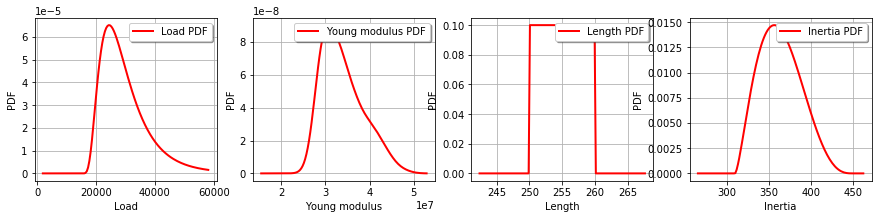

In [8]:
fig = pl.figure(figsize=(15, 3))
drawables = [
    marginal_distribution.drawPDF() for marginal_distribution in marginal_distributions
]
axes = [fig.add_subplot(1, 4, i) for i in range(1, 5)]
for axis, drawable in zip(axes, drawables):
    _ = View(drawable, figure=fig, axes=[axis])

Let then define the dependence structure as a Normal copula with a single non-zero Spearman correlation between components 2 and 3 of the final random vector, that is $L$ and $I$.

In [9]:
SR_cor = ot.CorrelationMatrix(len(marginal_distributions))
SR_cor[2, 3] = -0.2
copula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(SR_cor))

Eventually the input joint distribution is defined as a *composed distribution*.

In [10]:
X_distribution = ot.ComposedDistribution(marginal_distributions, copula)

# Definition of the physical model

First, let us define a Python function that implements the model $\mathcal{M}: \mathbf{x} \mapsto \mathbf{y}$.

In [11]:
class Wrapper(ot.OpenTURNSPythonFunction):
    """
    Wrapper of the beam code
    """

    def __init__(self, sleep_time=0):
        # initialize the OpenTURNSPythonFunction
        # number of inputs = 4
        # number of outputs = 1
        super(Wrapper, self).__init__(4, 1)
        # define attributes for the template file and the executable
        self.cwd = os.getcwd()
        self.template = self.cwd + os.sep + "beam" + os.sep + "beam_input_template.xml"
        self.executable = self.cwd + os.sep + "beam" + os.sep + "beam -v -x beam.xml"
        self.sleep_time = sleep_time

    def _exec(self, X):
        X = ot.Point(X)
        with otw.TempWorkDir(
            base_temp_work_dir="/tmp", cleanup=False, prefix="ot-beam-",
        ):
            sleep(self.sleep_time)
            # create input
            self._create_input_file(X)
            # run executable
            self._run()
            # parse output
            Y = self._parse_output()
            ot.Log.User(socket.gethostname())
            # ot.Log.Flush()
        return [Y]

    def _create_input_file(self, X):
        ot.coupling_tools.replace(
            self.template, "beam.xml", ["@F", "@E", "@L", "@I"], X
        )

    def _run(self):
        ot.coupling_tools.execute(self.executable)

    def _parse_output(self):
        xmldoc = minidom.parse("_beam_outputs_.xml")
        itemlist = xmldoc.getElementsByTagName("outputs")
        deviation = float(itemlist[0].attributes["deviation"].value)
        return deviation

## Sequential Function

We now define a sequential `Function`.

In [12]:
model_serial = ot.Function(Wrapper(0.2))
model_serial.setDescription(list(X_distribution.getDescription()) + ["deviation"])

Test the sequential function.

In [13]:
mean = X_distribution.getMean()
model_serial(mean)

class=Point name=Unnamed dimension=1 values=[13.4534]

## Distributed `Function` using `OtWraPy`

We create a parallelized function using otw.Parallelizer

In [14]:
# backend = 'ipyparallel', 'joblib', 'pathos' or 'multiprocessing'.

In [15]:
model = otw.Parallelizer(model_serial, backend="multiprocessing", n_cpus=2, verbosity=5)
model.setDescription(list(X_distribution.getDescription()) + ["deviation"])

Now, let's execute the function on a sequence of inputs.

In [16]:
sampleSize = 50

In [17]:
%time y = [model_serial(x) for x in X_distribution.getSample(sampleSize)]

CPU times: user 89.5 ms, sys: 121 ms, total: 211 ms
Wall time: 10.6 s


In [18]:
some_inputs = X_distribution.getSample(sampleSize)
%time some_outputs = model(some_inputs)

CPU times: user 33 ms, sys: 7.37 ms, total: 40.4 ms
Wall time: 6.01 s


In [19]:
inputs_outputs = ot.Sample(some_inputs)
inputs_outputs.stack(some_outputs)
inputs_outputs[:5, :]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=5 description=[Load,Young modulus,Length,Inertia,deviation] data=[[35702,2.93847e+07,251.796,399.501,16.1837],[30206.5,3.57598e+07,256.828,340.312,14.0163],[23873.7,3.23688e+07,251.656,338.425,11.578],[43396.5,3.04774e+07,250.416,395.165,18.8609],[83949.1,4.33825e+07,250.496,345.814,29.3186]]

In [20]:
print('Class : ', model.getClassName())
print('Input : ', model.getDescription())
print('Ouput : ', model.getOutputDescription())
print('Evaluation : ', model.getEvaluation())
print('Gradient : ', model.getGradient())
print('Hessian : ', model.getHessian())

Class :  MemoizeFunction
Input :  [Load,Young modulus,Length,Inertia,deviation]
Ouput :  [deviation]
Evaluation :  class=PythonEvaluation name=Parallelizer
Gradient :  CenteredFiniteDifferenceGradient epsilon : [1e-05,1e-05,1e-05,1e-05]
Hessian :  CenteredFiniteDifferenceHessian epsilon : [0.0001,0.0001,0.0001,0.0001]


## Fine setup the `Function`
OpenTURNS implements a cache mechanism that stores function calls (input and output) in order to save useless repeated calls.

In [21]:
model.enableCache()
print(
    "Current cache max size is %d."
    % ot.ResourceMap.GetAsUnsignedInteger("cache-max-size")
)

Current cache max size is 1024.


We now set the gradient and hessian implementations using **finite difference schemes**.

In [22]:
model.setGradient(
    ot.NonCenteredFiniteDifferenceGradient(
        np.array(X_distribution.getStandardDeviation()) * 5e-6, model.getEvaluation()
    )
)

In [23]:
model.setHessian(
    ot.CenteredFiniteDifferenceHessian(
        np.array(X_distribution.getStandardDeviation()) * 5e-4, model.getEvaluation()
    )
)

# Definition of the output random vector

The output distribution is unknown, but we can make a random vector out of it.

In [24]:
Y_random_vector = ot.CompositeRandomVector(model, ot.RandomVector(X_distribution))

# Central tendancy analysis

## Monte Carlo simulation

One seeks here to evaluate the characteristics of the central part (location and spread, that is: mean or median and variance or interquartile) of the probability distribution of the variable deviation $Y$ by means of Monte Carlo (say pseudo-random) sampling.

In [25]:
sample_size = 100

In [26]:
ot.RandomGenerator.SetSeed(1)

In [27]:
Y_sample = Y_random_vector.getSample(sample_size)

The `getSample` method of the output random vector generates a sample out of the input distribution and propagate it through our model. Now we can estimate summary statistics from that sample.

In [28]:
Y_mean = Y_sample.computeMean()[0]
Y_var = Y_sample.computeVariance()[0]
Y_stdv = Y_sample.computeStandardDeviationPerComponent()[0]
Y_skew = Y_sample.computeSkewness()[0]
Y_kurt = Y_sample.computeKurtosis()[0]

print("----------------------------")
print("Response sample statistics  ")
print("----------------------------")
print("Size                  = %d" % Y_sample.getSize())
print("Mean                  = %.2f" % Y_mean)
print("Variance              = %.2f" % Y_var)
print("Standart-deviation    = %.2f" % Y_stdv)
print("Skewness              = %.2f" % Y_skew)
print("Kurtosis              = %.2f" % Y_kurt)
print("Median                = %.2f" % Y_sample.computeQuantile(0.5)[0])
print(
    "Interquartile         = [%.2f, %.2f]"
    % (Y_sample.computeQuantile(0.25)[0], Y_sample.computeQuantile(0.75)[0])
)
print(
    "CI at 95 %%            = [%.2f, %.2f]"
    % (Y_sample.computeQuantile(0.025)[0], Y_sample.computeQuantile(0.975)[0])
)
print("----------------------------")

----------------------------
Response sample statistics  
----------------------------
Size                  = 100
Mean                  = 14.53
Variance              = 27.46
Standart-deviation    = 5.24
Skewness              = 1.18
Kurtosis              = 4.49
Median                = 12.87
Interquartile         = [11.10, 17.22]
CI at 95 %            = [7.66, 26.88]
----------------------------


### Computation of the confidence intervals at 95% of the mean and variance estimators of $Y$ obtained from this sample

Since sampling is a random experiment, statistics may differ from one sample to the other. Fortunately, the estimation theory provides theorem enabling convergence diagnostics. For instance, the following two theorems provides the asymptotic distribution for the mean and variance estimators. These distributions can then be used to compute confidence interval.

In [29]:
confidence_level = .95

* The **central limit theorem** states that the empirical mean tends asymptotically to a Gaussian distribution:  

$N \longrightarrow \infty,\,\,\,\,\,\,\bar V \sim \mathcal{N} \left( m,\dfrac{\sigma}{\sqrt{N}}  \right)$

In [30]:
Y_mean_asymptotic_variance = Y_var / sample_size
Y_mean_asymptotic_distribution = ot.Normal(Y_mean, np.sqrt(Y_mean_asymptotic_variance))
Y_mean_confidence_interval = (
    Y_mean_asymptotic_distribution.computeQuantile((1.0 - confidence_level) / 2.0)[0],
    Y_mean_asymptotic_distribution.computeQuantile(
        1.0 - (1.0 - confidence_level) / 2.0
    )[0],
)
print("95%%-CI for the mean = [%.2f, %.2f]" % Y_mean_confidence_interval)

95%-CI for the mean = [13.50, 15.56]


* **Cochran's theorem** gives the asymptotic distribution of the variance estimator $\sigma^2$ : 

$N \longrightarrow \infty,\,\,\,\,\,\,(N-1)\,\dfrac{S^2_{N-1}}{\sigma^2}\,\sim \, \mathcal{\chi}_{N-1}^2\,\,\,\,\text{where}\,\,\,\,S^2_{N-1} = \dfrac{1}{N-1} \sum_{i=1}^N \left(V_i-\bar V\right)^2$
 

In [31]:
Y_var_confidence_interval = (
    Y_var
    * (sample_size - 1.0)
    / ot.ChiSquare(sample_size - 1).computeQuantile((confidence_level) / 2.0)[0],
    Y_var
    * (sample_size - 1.0)
    / ot.ChiSquare(sample_size - 1).computeQuantile((1.0 - confidence_level) / 2.0)[0],
)

print("95%%-CI for the variance = [%.2f, %.2f]" % Y_var_confidence_interval)

95%-CI for the variance = [27.89, 37.06]


### FOSM analysis

The **first-order second-moment** approach is an alternative approximate method for calculating the mean and variance of the output variables.

This method is based on a Taylor series expansion of the model $\mathcal M$, in the vicinity of the input's mean $\mathbf \mu_X$ . 

In [32]:
FOSM_approximation = ot.TaylorExpansionMoments(Y_random_vector)

In [33]:
Y_mean_FOSM_1st_order = FOSM_approximation.getMeanFirstOrder()[0]
Y_mean_FOSM_2nd_order = FOSM_approximation.getMeanSecondOrder()[0]
Y_var_FOSM = FOSM_approximation.getCovariance()[0, 0]
Y_stdv_FOSM = np.sqrt(Y_var_FOSM)
print("Mean 1st order     = %.2f" % Y_mean_FOSM_1st_order)
print("Mean 2nd order     = %.2f" % Y_mean_FOSM_2nd_order)
print("Variance           = %.2f" % Y_var_FOSM)
print("Standard deviation = %.2f" % Y_stdv_FOSM)

Mean 1st order     = 13.45
Mean 2nd order     = 13.82
Variance           = 21.25
Standard deviation = 4.61


# Analysis of variance

## FOSM importance factors


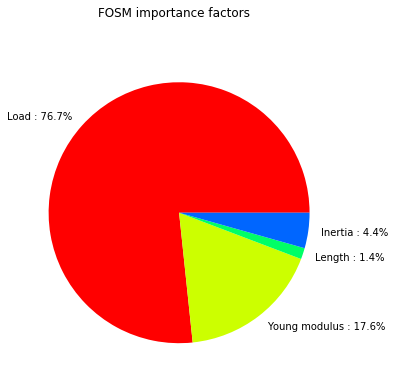

In [34]:
FOSM_importance_factors = FOSM_approximation.getImportanceFactors()
FOSM_importance_factors_graph = FOSM_approximation.drawImportanceFactors()
FOSM_importance_factors_graph.setTitle("FOSM importance factors")
_ = View(FOSM_importance_factors_graph, figure=pl.figure(figsize=(6, 6)))

## Graphical sensitivity analysis

Let's get the cached function calls... and concatenate all sample together.

In [35]:
cached_inputs = model.getCacheInput()
cached_outputs = model.getCacheOutput()

all_sample = cached_inputs[:]
all_sample.stack(cached_outputs)
all_sample.setDescription(model.getDescription())

... And make **scatter plots** out of it:

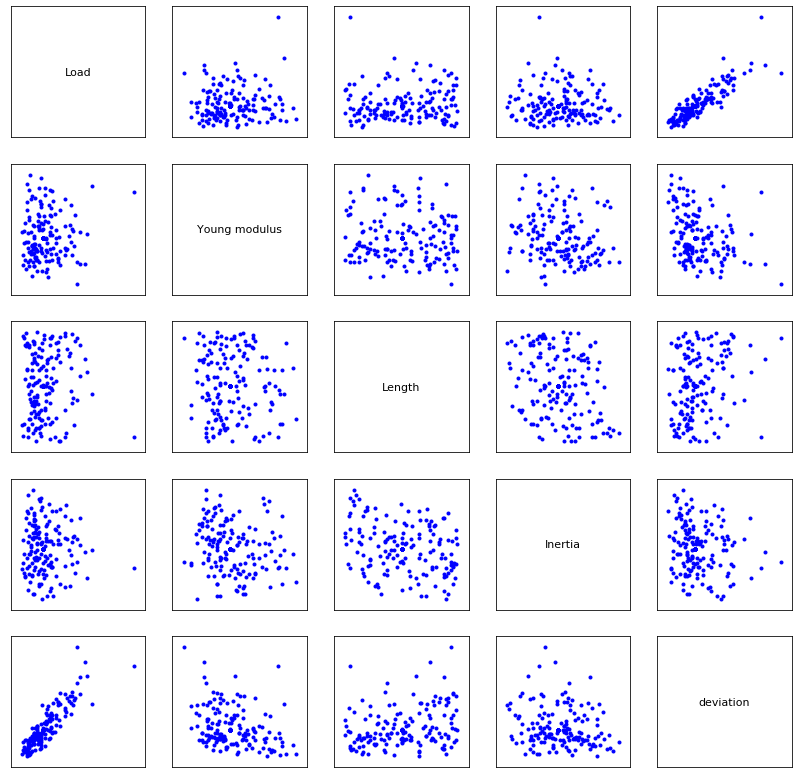

In [36]:
fig, ax = pl.subplots(figsize=(14, 14))
View(ot.Pairs(all_sample), plot_kwargs={'marker':'.'}, axes=[ax]);

... Or a **Cobweb plot**:

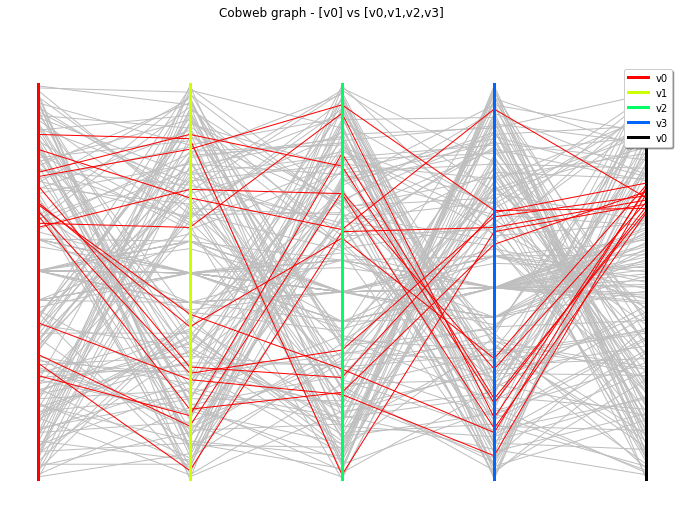

In [37]:
cobweb_plot = ot.VisualTest_DrawCobWeb(
    cached_inputs,
    cached_outputs,
    Y_mean - 0.1 * Y_stdv,
    Y_mean + 0.2 * Y_stdv,
    "red",
    False,
)
_ = View(cobweb_plot, figure=pl.figure(figsize=(12, 8)))